In [1]:
## ALL IMPORTS FOR A NEW NOTEBOOK

import os, sys, random, math
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import itertools as it
import scipy
import glob
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch.optim import Optimizer
import torchvision.transforms.transforms as txf
import torch.optim.lr_scheduler as lr_scheduler
from collections import OrderedDict

from sklearn import metrics
from sklearn import preprocessing as pp
from sklearn import model_selection as ms

import torch_utils
from tqdm.notebook import tqdm_notebook as tqdm
import time

font = {'size'   : 20}

matplotlib.rc('font', **font)

In [2]:
SEED = 947
torch_utils.seed_everything(947)

In [3]:
import spacy
spacy_de = spacy.load("de")
spacy_en = spacy.load("en")

In [4]:
def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def tokenize_de(text):
    return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

In [5]:
from torchtext import data, datasets

In [6]:
SRC = data.Field(
    tokenize=tokenize_de,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True
)
TRG = data.Field(
    tokenize=tokenize_en,
    init_token="<sos>",
    eos_token="<eos>",
    lower=True
)

In [7]:
train_data, valid_data, test_data = datasets.Multi30k.splits(exts=(".de",".en"), fields=(SRC, TRG))

In [8]:
len(train_data),len(valid_data), len(test_data)

(29000, 1014, 1000)

In [9]:
vars(train_data.examples[0])

{'src': ['.',
  'büsche',
  'vieler',
  'nähe',
  'der',
  'in',
  'freien',
  'im',
  'sind',
  'männer',
  'weiße',
  'junge',
  'zwei'],
 'trg': ['two',
  'young',
  ',',
  'white',
  'males',
  'are',
  'outside',
  'near',
  'many',
  'bushes',
  '.']}

In [10]:
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [11]:
print(len(SRC.vocab)," words in Source")
print(len(TRG.vocab)," words in Target")

7855  words in Source
5893  words in Target


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [13]:
BATCH_SIZE = 128
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data,valid_data, test_data),
    batch_sizes=(BATCH_SIZE,BATCH_SIZE,BATCH_SIZE),
    device=device
)

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, src):
        # srclen x batch_size (standard lstm input shape)
        embedded = self.dropout(self.embedding(src))
        #srclen X batch_size X emb_dim
        ot,(ht,ct) = self.rnn(embedded)
        # ot = src_len X batch_size X hidden_dim*n_directions
        # ht = n_layers*n_directions X batch_size X hid_dim
        # ct = n_layers*n_directions X batch_size X hid_dim
        
        return ht, ct

In [15]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, trg, ht, ct):
        # trg = batch_size
        # ht = n_directions*n_layers X batch_size X hid_dim
        # ct = n_directions*n_layers X batch_size X hid_dim
        
        # add a fake seq_len dimension
        trg = trg.unsqueeze(0)
        embedded = self.dropout(self.embedding(trg))
        
        # embedded = 1 X batch_size X emb_dim
        
        ot, (ht, ct) = self.rnn(embedded, (ht, ct))
        
        preds = self.fc_out(ot.squeeze(0))
        
        return preds, (ht, ct)

In [16]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
        assert encoder.hid_dim == decoder.hid_dim, "ENC_HID_DIM MUST == DEC_HID_DIM"
        assert encoder.n_layers == decoder.n_layers, "ENC_LAYERS MUST == DEC_LAYERS"
    
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        ht,ct = self.encoder(src)
        
        current_token = trg[0, :]
        
        for t in range(1, trg_len):
            ot, (ht, ct) = self.decoder(current_token, ht, ct)
            outputs[t] = ot
            
            teacher_force = random.random() < teacher_forcing_ratio
            
            top1 = ot.argmax(1)
            
            current_token = trg[t] if teacher_force else top1

        return outputs

In [17]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    l = 0
    
    for i, batch in enumerate(tqdm(iterator)):
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        output = model(src, trg)
        
        output_dim = output.shape[-1]
        
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        l+=loss.item()
    
    return l/len(iterator)

In [18]:
def evaluate(model, iterator, criterion):
    model.eval()
    l = 0
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(iterator)):
            src = batch.src
            trg = batch.trg
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)
            loss = criterion(output, trg)
            l+=loss.item()
    
    return l/len(iterator)

In [19]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

In [29]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 4
ENC_DROP = 0.5
DEC_DROP = 0.5

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROP)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROP)


torch_utils.clear_cuda()

model = Seq2Seq(enc, dec, device).to(device)
model = model.apply(init_weights)

In [30]:
torch_utils.count_model_params(model)

22304005

In [31]:
optimizer = torch_utils.RAdam(model.parameters())
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)
N_EPOCHS = 120
CLIP = 1
history = pd.DataFrame()
ea = torch_utils.EarlyStopping(patience=30, verbose=True)

In [32]:
for epoch in range(N_EPOCHS):
    st = time.time()
    torch_utils.clear_cuda()
    tl = train(model, train_iterator, optimizer, criterion, CLIP)
    vl = evaluate(model, valid_iterator, criterion)
    torch_utils.print_epoch_stat(epoch, time.time()-st, history=history, train_loss=tl, valid_loss=vl)
    history.loc[epoch, "TPL"] = math.exp(tl)
    history.loc[epoch, "VPL"] = math.exp(vl)
    ea(history.loc[epoch, "VPL"], model)
    
    print("\tTPL: \t{:0.5}".format(history.loc[epoch, "TPL"]))
    print("\tVPL: \t{:0.5}".format(history.loc[epoch, "VPL"]))
    
    if ea.early_stop:
        print("STOPPING EARLY")
        break




EPOCH 1 Completed, Time Taken: 0:00:44.795898
	Train Loss 	5.63975161
	Valid Loss 	4.86798364
Found better solution (inf --> 130.058408).  Saving model ...
	TPL: 	281.39
	VPL: 	130.06





EPOCH 2 Completed, Time Taken: 0:00:44.427731
	Train Loss 	4.88571305
	Valid Loss 	4.76346862
Found better solution (130.058408 --> 117.151577).  Saving model ...
	TPL: 	132.38
	VPL: 	117.15





EPOCH 3 Completed, Time Taken: 0:00:45.138107
	Train Loss 	4.8213366
	Valid Loss 	4.69971162
Found better solution (117.151577 --> 109.915471).  Saving model ...
	TPL: 	124.13
	VPL: 	109.92





EPOCH 4 Completed, Time Taken: 0:00:44.496018
	Train Loss 	4.64827843
	Valid Loss 	4.37330577
Found better solution (109.915471 --> 79.305364).  Saving model ...
	TPL: 	104.41
	VPL: 	79.305





EPOCH 5 Completed, Time Taken: 0:00:44.375622
	Train Loss 	4.31370591
	Valid Loss 	4.11639553
Found better solution (79.305364 --> 61.337753).  Saving model ...
	TPL: 	74.717
	VPL: 	61.338





EPOCH 6 Completed, Time Taken: 0:00:44.375015
	Train Loss 	4.09666263
	Valid Loss 	3.89491615
Found better solution (61.337753 --> 49.151932).  Saving model ...
	TPL: 	60.139
	VPL: 	49.152





EPOCH 7 Completed, Time Taken: 0:00:44.996785
	Train Loss 	3.87897279
	Valid Loss 	3.66821069
Found better solution (49.151932 --> 39.181735).  Saving model ...
	TPL: 	48.374
	VPL: 	39.182





EPOCH 8 Completed, Time Taken: 0:00:45.636752
	Train Loss 	3.70525066
	Valid Loss 	3.53041098
Found better solution (39.181735 --> 34.137995).  Saving model ...
	TPL: 	40.66
	VPL: 	34.138





EPOCH 9 Completed, Time Taken: 0:00:44.610334
	Train Loss 	3.54921911
	Valid Loss 	3.49416605
Found better solution (34.137995 --> 32.922820).  Saving model ...
	TPL: 	34.786
	VPL: 	32.923





EPOCH 10 Completed, Time Taken: 0:00:44.313536
	Train Loss 	3.40470991
	Valid Loss 	3.31723276
Found better solution (32.922820 --> 27.583913).  Saving model ...
	TPL: 	30.106
	VPL: 	27.584





EPOCH 11 Completed, Time Taken: 0:00:44.809708
	Train Loss 	3.26993547
	Valid Loss 	3.14876747
Found better solution (27.583913 --> 23.307320).  Saving model ...
	TPL: 	26.31
	VPL: 	23.307





EPOCH 12 Completed, Time Taken: 0:00:45.560820
	Train Loss 	3.16827356
	Valid Loss 	3.09410393
Found better solution (23.307320 --> 22.067456).  Saving model ...
	TPL: 	23.766
	VPL: 	22.067





EPOCH 13 Completed, Time Taken: 0:00:44.575445
	Train Loss 	3.06283194
	Valid Loss 	3.00369462
Found better solution (22.067456 --> 20.159883).  Saving model ...
	TPL: 	21.388
	VPL: 	20.16





EPOCH 14 Completed, Time Taken: 0:00:44.680952
	Train Loss 	2.95879141
	Valid Loss 	2.9782277
Found better solution (20.159883 --> 19.652955).  Saving model ...
	TPL: 	19.275
	VPL: 	19.653





EPOCH 15 Completed, Time Taken: 0:00:44.597062
	Train Loss 	2.88548069
	Valid Loss 	2.94066799
Found better solution (19.652955 --> 18.928486).  Saving model ...
	TPL: 	17.912
	VPL: 	18.928





EPOCH 16 Completed, Time Taken: 0:00:44.436888
	Train Loss 	2.79999031
	Valid Loss 	2.97401917
EarlyStopping counter: 1 out of 30
	TPL: 	16.444
	VPL: 	19.57





EPOCH 17 Completed, Time Taken: 0:00:45.143218
	Train Loss 	2.72507216
	Valid Loss 	2.87761053
Found better solution (18.928486 --> 17.771757).  Saving model ...
	TPL: 	15.258
	VPL: 	17.772





EPOCH 18 Completed, Time Taken: 0:00:45.173664
	Train Loss 	2.64874595
	Valid Loss 	2.93301946
EarlyStopping counter: 1 out of 30
	TPL: 	14.136
	VPL: 	18.784





EPOCH 19 Completed, Time Taken: 0:00:46.072360
	Train Loss 	2.57388404
	Valid Loss 	2.91343904
EarlyStopping counter: 2 out of 30
	TPL: 	13.117
	VPL: 	18.42





EPOCH 20 Completed, Time Taken: 0:00:45.379205
	Train Loss 	2.51353712
	Valid Loss 	2.8406322
Found better solution (17.771757 --> 17.126590).  Saving model ...
	TPL: 	12.349
	VPL: 	17.127





EPOCH 21 Completed, Time Taken: 0:00:45.188381
	Train Loss 	2.44326747
	Valid Loss 	2.87929279
EarlyStopping counter: 1 out of 30
	TPL: 	11.511
	VPL: 	17.802





EPOCH 22 Completed, Time Taken: 0:00:44.704862
	Train Loss 	2.39806401
	Valid Loss 	2.81410104
Found better solution (17.126590 --> 16.678176).  Saving model ...
	TPL: 	11.002
	VPL: 	16.678





EPOCH 23 Completed, Time Taken: 0:00:44.437790
	Train Loss 	2.32065462
	Valid Loss 	2.77978858
Found better solution (16.678176 --> 16.115613).  Saving model ...
	TPL: 	10.182
	VPL: 	16.116





EPOCH 24 Completed, Time Taken: 0:00:45.539572
	Train Loss 	2.26758967
	Valid Loss 	2.81117207
EarlyStopping counter: 1 out of 30
	TPL: 	9.6561
	VPL: 	16.629





EPOCH 25 Completed, Time Taken: 0:00:45.690266
	Train Loss 	2.20604986
	Valid Loss 	2.7289317
Found better solution (16.115613 --> 15.316516).  Saving model ...
	TPL: 	9.0798
	VPL: 	15.317





EPOCH 26 Completed, Time Taken: 0:00:45.940377
	Train Loss 	2.16197325
	Valid Loss 	2.7488834
EarlyStopping counter: 1 out of 30
	TPL: 	8.6883
	VPL: 	15.625





EPOCH 27 Completed, Time Taken: 0:00:45.959497
	Train Loss 	2.11449458
	Valid Loss 	2.90339702
EarlyStopping counter: 2 out of 30
	TPL: 	8.2854
	VPL: 	18.236


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-ed4533b0b2d2>", line 4, in <module>
    tl = train(model, train_iterator, optimizer, criterion, CLIP)
  File "<ipython-input-17-d310ed64b68e>", line 10, in train
    output = model(src, trg)
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-16-3809ac9f2136>", line 23, in forward
    ot, (ht, ct) = self.decoder(current_token, ht, ct)
  File "/home/numan947/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/modules/module.py", line 532, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-15-e50aa1e32d28>", line 24, in forward
    ot, (ht, ct) = self.rnn(embedded, (ht, ct

KeyboardInterrupt: 

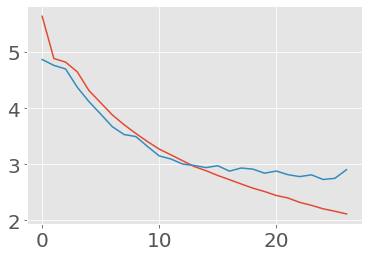

In [33]:
ax = history["train_loss"].plot()
history["valid_loss"].plot(ax=ax)

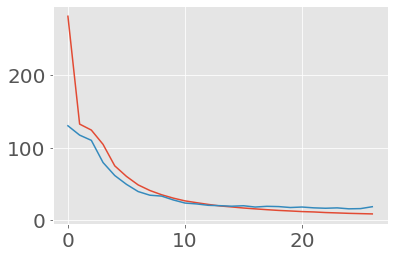

In [34]:
ax = history["TPL"].plot()
history["VPL"].plot(ax=ax)

In [35]:
l = evaluate(model, test_iterator, criterion)

print("LOSS: ",l," PPL: ", math.exp(l))


LOSS:  2.8072732985019684  PPL:  16.5646896203634


In [36]:
model.load_state_dict(torch.load("checkpoint.pt", map_location=device))

<All keys matched successfully>

In [37]:
l = evaluate(model, test_iterator, criterion)

print("LOSS: ",l," PPL: ", math.exp(l))


LOSS:  2.892803907394409  PPL:  18.043831972316347
